In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [4]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [5]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [6]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [7]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [8]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

negatif    0.370049
positif    0.335594
netral     0.294357
Name: label, dtype: float64

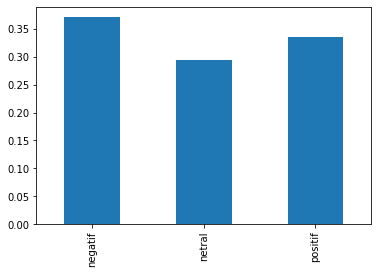

In [11]:
diagram_coba = y_train.value_counts(normalize=True)
diagram_coba[["negatif", "netral", "positif"]].plot(kind="bar")
diagram_coba

In [10]:
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.28405	test-merror:0.38191
[1]	train-merror:0.21785	test-merror:0.34422
[2]	train-merror:0.18367	test-merror:0.33920
[3]	train-merror:0.16685	test-merror:0.33920
[4]	train-merror:0.14976	test-merror:0.33417
[5]	train-merror:0.13646	test-merror:0.30653
[6]	train-merror:0.12887	test-merror:0.29397
[7]	train-merror:0.12208	test-merror:0.28643
[8]	train-merror:0.11584	test-merror:0.28895
[9]	train-merror:0.11530	test-merror:0.29397
[10]	train-merror:0.11449	test-merror:0.28643
[11]	train-merror:0.11123	test-merror:0.29648
[12]	train-merror:0.11042	test-merror:0.28895
[13]	train-merror:0.10798	test-merror:0.28643
[14]	train-merror:0.10608	test-merror:0.28392
[15]	train-merror:0.10228	test-merror:0.28643
[16]	train-merror:0.10065	test-merror:0.29397
[17]	train-merror:0.10065	test-merror:0.29146
[18]	train-merror:0.09902	test-merror:0.28141
[19]	train-merror:0.09821	test-merror:0.27889
[20]	train-merror:0.09712	test-merror:0.27638
[21]	train-merror:0.09848	test-merror:0.2713

[177]	train-merror:0.05480	test-merror:0.25628
[178]	train-merror:0.05562	test-merror:0.25377
[179]	train-merror:0.05480	test-merror:0.25377
[180]	train-merror:0.05453	test-merror:0.25126
[181]	train-merror:0.05453	test-merror:0.25377
[182]	train-merror:0.05453	test-merror:0.25628
[183]	train-merror:0.05480	test-merror:0.25377
[184]	train-merror:0.05426	test-merror:0.25126
[185]	train-merror:0.05399	test-merror:0.25126
[186]	train-merror:0.05399	test-merror:0.25126
[187]	train-merror:0.05426	test-merror:0.24874
[188]	train-merror:0.05480	test-merror:0.25126
[189]	train-merror:0.05453	test-merror:0.25126
[190]	train-merror:0.05399	test-merror:0.24874
[191]	train-merror:0.05372	test-merror:0.24874
[192]	train-merror:0.05290	test-merror:0.24874
[193]	train-merror:0.05290	test-merror:0.24874
[194]	train-merror:0.05209	test-merror:0.24874
[195]	train-merror:0.05209	test-merror:0.24874
[196]	train-merror:0.05209	test-merror:0.24874
[197]	train-merror:0.05236	test-merror:0.24874
[198]	train-m

[352]	train-merror:0.03690	test-merror:0.24372
[353]	train-merror:0.03690	test-merror:0.24121
[354]	train-merror:0.03690	test-merror:0.24121
[355]	train-merror:0.03690	test-merror:0.24121
[356]	train-merror:0.03662	test-merror:0.24623
[357]	train-merror:0.03608	test-merror:0.24623
[358]	train-merror:0.03635	test-merror:0.24623
[359]	train-merror:0.03635	test-merror:0.24623
[360]	train-merror:0.03554	test-merror:0.24623
[361]	train-merror:0.03608	test-merror:0.24623
[362]	train-merror:0.03500	test-merror:0.24623
[363]	train-merror:0.03500	test-merror:0.24623
[364]	train-merror:0.03500	test-merror:0.24623
[365]	train-merror:0.03500	test-merror:0.24623
[366]	train-merror:0.03473	test-merror:0.24623
[367]	train-merror:0.03445	test-merror:0.24623
[368]	train-merror:0.03527	test-merror:0.24623
[369]	train-merror:0.03473	test-merror:0.24623
[370]	train-merror:0.03445	test-merror:0.24874
[371]	train-merror:0.03418	test-merror:0.24623
[372]	train-merror:0.03418	test-merror:0.24874
[373]	train-m

[527]	train-merror:0.01872	test-merror:0.24623
[528]	train-merror:0.01899	test-merror:0.24874
[529]	train-merror:0.01872	test-merror:0.24874
[530]	train-merror:0.01872	test-merror:0.24874
[531]	train-merror:0.01872	test-merror:0.24623
[532]	train-merror:0.01845	test-merror:0.24623
[533]	train-merror:0.01845	test-merror:0.24623
[534]	train-merror:0.01845	test-merror:0.24623
[535]	train-merror:0.01845	test-merror:0.24623
[536]	train-merror:0.01845	test-merror:0.24623
[537]	train-merror:0.01845	test-merror:0.24623
[538]	train-merror:0.01845	test-merror:0.24623
[539]	train-merror:0.01845	test-merror:0.24623
[540]	train-merror:0.01845	test-merror:0.24623
[541]	train-merror:0.01845	test-merror:0.24623
[542]	train-merror:0.01845	test-merror:0.24623
[543]	train-merror:0.01818	test-merror:0.24372
[544]	train-merror:0.01818	test-merror:0.24372
[545]	train-merror:0.01818	test-merror:0.24372
[546]	train-merror:0.01818	test-merror:0.24623
[547]	train-merror:0.01763	test-merror:0.24623
[548]	train-m

[702]	train-merror:0.00977	test-merror:0.24874
[703]	train-merror:0.00977	test-merror:0.24874
[704]	train-merror:0.00977	test-merror:0.24874
[705]	train-merror:0.00977	test-merror:0.24874
[706]	train-merror:0.00977	test-merror:0.24874
[707]	train-merror:0.00977	test-merror:0.24874
[708]	train-merror:0.00977	test-merror:0.24874
[709]	train-merror:0.00977	test-merror:0.24874
[710]	train-merror:0.00977	test-merror:0.24623
[711]	train-merror:0.00977	test-merror:0.24874
[712]	train-merror:0.00977	test-merror:0.25126
[713]	train-merror:0.00977	test-merror:0.25126
[714]	train-merror:0.00949	test-merror:0.25126
[715]	train-merror:0.00949	test-merror:0.24874
[716]	train-merror:0.00949	test-merror:0.24874
[717]	train-merror:0.00949	test-merror:0.25126
[718]	train-merror:0.00949	test-merror:0.25126
[719]	train-merror:0.00949	test-merror:0.25126
[720]	train-merror:0.00922	test-merror:0.25126
[721]	train-merror:0.00922	test-merror:0.25126
[722]	train-merror:0.00922	test-merror:0.25126
[723]	train-m

[877]	train-merror:0.00624	test-merror:0.25126
[878]	train-merror:0.00624	test-merror:0.25126
[879]	train-merror:0.00624	test-merror:0.25126
[880]	train-merror:0.00624	test-merror:0.25126
[881]	train-merror:0.00624	test-merror:0.25126
[882]	train-merror:0.00624	test-merror:0.25126
[883]	train-merror:0.00624	test-merror:0.25126
[884]	train-merror:0.00624	test-merror:0.25126
[885]	train-merror:0.00624	test-merror:0.25126
[886]	train-merror:0.00624	test-merror:0.25126
[887]	train-merror:0.00624	test-merror:0.25126
[888]	train-merror:0.00624	test-merror:0.25126
[889]	train-merror:0.00624	test-merror:0.25126
[890]	train-merror:0.00624	test-merror:0.25126
[891]	train-merror:0.00624	test-merror:0.25126
[892]	train-merror:0.00624	test-merror:0.25126
[893]	train-merror:0.00624	test-merror:0.25126
[894]	train-merror:0.00624	test-merror:0.25126
[895]	train-merror:0.00624	test-merror:0.24874
[896]	train-merror:0.00624	test-merror:0.25126
[897]	train-merror:0.00624	test-merror:0.24874
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7437185929648241 

Train Score
 0.9945740640260445 

CONFUSSION MATRIX
 [[ 20   3  43]
 [  6   5  11]
 [ 29  10 271]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.36      0.30      0.33        66
      netral       0.28      0.23      0.25        22
     positif       0.83      0.87      0.85       310

    accuracy                           0.74       398
   macro avg       0.49      0.47      0.48       398
weighted avg       0.73      0.74      0.73       398
 



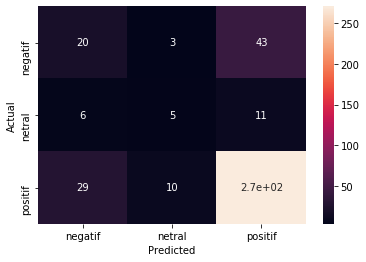

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])